# Daily Models

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn import metrics
from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima

from fbprophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation,rmse, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot


plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


import warnings
warnings.filterwarnings('ignore')

In [3]:
#df = pd.read_csv('../capstone-data/daily-uni.csv')

In [5]:
df = pd.read_csv('../../capstone-data/daily-merged.csv')

In [6]:
df.rename(columns={'Unnamed: 0':'date'},inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df= df.asfreq('d')

In [7]:
df['total_rides'].mean(), df['total_rides'].std()

(1292590.6114674695, 452648.37201676704)

# Linear Model Setup

Testing lags for future modeling.

In [8]:
test = df[['total_rides']].copy()
test['test_lags'] = test['total_rides'].shift(31)
test.corr()

,total_rides,test_lags
total_rides,1.000000,0.087953
test_lags,0.087953,1.000000


In [9]:
rides = df[['total_rides']].copy()

In [10]:
rides['lag_1'] = rides['total_rides'].shift(1)
rides['lag_2'] = rides['total_rides'].shift(2)
rides['lag_3'] = rides['total_rides'].shift(3)
rides['lag_4'] = rides['total_rides'].shift(4)
rides['lag_5'] = rides['total_rides'].shift(5)
rides['lag_6'] = rides['total_rides'].shift(6)
rides['lag_7'] = rides['total_rides'].shift(7)
rides['lag_8'] = rides['total_rides'].shift(8)
rides['lag_364'] = rides['total_rides'].shift(364)

rides['time'] = range(0, rides.shape[0])

In [11]:
rides.corr()

,total_rides,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_364,time
total_rides,1.000000,0.576230,0.177608,0.124148,0.118786,0.162800,0.540037,0.897420,0.534499,0.840756,-0.256540
lag_1,0.576230,1.000000,0.576144,0.177346,0.123889,0.118532,0.162509,0.539932,0.897401,0.420641,-0.256344
lag_2,0.177608,0.576144,1.000000,0.576013,0.177078,0.123609,0.118186,0.162293,0.539835,0.011178,-0.256125
lag_3,0.124148,0.177346,0.576013,1.000000,0.575788,0.176651,0.123042,0.117823,0.162015,-0.042955,-0.255770
lag_4,0.118786,0.123889,0.177078,0.575788,1.000000,0.575589,0.176171,0.122714,0.117554,-0.045188,-0.255446
lag_5,0.162800,0.118532,0.123609,0.176651,0.575589,1.000000,0.575355,0.175870,0.122453,0.003737,-0.255131
lag_6,0.540037,0.162509,0.118186,0.123042,0.176171,0.575355,1.000000,0.575187,0.175575,0.403165,-0.254743
lag_7,0.897420,0.539932,0.162293,0.117823,0.122714,0.175870,0.575187,1.000000,0.575088,0.774284,-0.254491
lag_8,0.534499,0.897401,0.539835,0.162015,0.117554,0.122453,0.175575,0.575088,1.000000,0.394028,-0.254287
lag_364,0.840756,0.420641,0.011178,-0.042955,-0.045188,0.003737,0.403165,0.774284,0.394028,1.000000,-0.135915


## Linear TimeSeries Model

In [22]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides','lag_4','lag_2',}),
                                                 rides['total_rides'],
                                                 test_size=.2,
                                                 shuffle=False)

In [23]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_3,lag_5,lag_6,lag_7,lag_8,lag_364,time
date,,,,,,,,,
2001-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-01-02,1.0,423647.0,NaN,NaN,NaN,NaN,NaN,NaN,1
2001-01-03,1.0,1282779.0,NaN,NaN,NaN,NaN,NaN,NaN,2
2001-01-04,1.0,1361355.0,423647.0,NaN,NaN,NaN,NaN,NaN,3
2001-01-05,1.0,1420032.0,1282779.0,NaN,NaN,NaN,NaN,NaN,4


In [24]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     6190.
Date:                Sun, 06 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:52:30   Log-Likelihood:                -75635.
No. Observations:                5747   AIC:                         1.513e+05
Df Residuals:                    5738   BIC:                         1.513e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.918e+04   1.73e+04     -1.112      0.266    -5.3e+04    1.46e+04
lag_1          0.1656      0.009     19.185      0.000       0.149       0.183
lag_3          0.0123      0.005      2.523      0.012       0.003       0.022
lag_5         -0.0015      0.005     -0.276      0.783      -0.012       0.009
lag_6          0.0245      0.006      4.255      0.000       0.013       0.036
lag_7          0.2627      0.009     30.242      0.000       0.246       0.280
lag_8         -0.1225      0.009    -13.946      0.000      -0.140      -0.105
lag_364        0.6871      0.008     82.626      0.000       0.671       0.703
time          -6.1503      1.035     -5.944      0.000      -8.179      -4.122
==============================================================================
Omnibus:                     2119.652   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80673.705
Skew:                          -1.077   Prob(JB):                         0.00
Kurtosis:                      21.228   Cond. No.                     3.84e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
metrics.r2_score(y_test,lm_results.predict(X_test))

0.5993377758806566

In [26]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

317766.5220055624

In [27]:
lm_results.aic

151287.11032504262

Initial and basic testing shows we are off by around 317,000 riders per day with an AIC of 151,300.

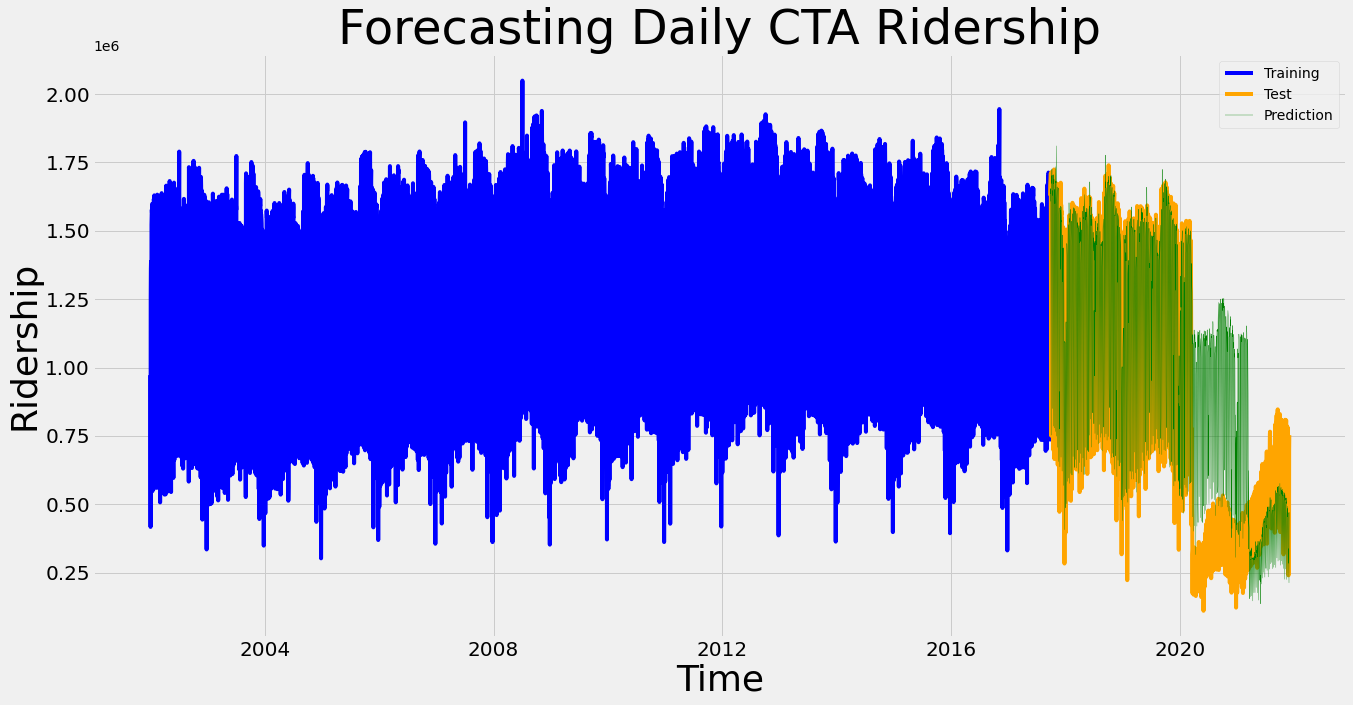

In [28]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction',linewidth=.35)
# Set label.
plt.title(label = 'Forecasting Daily CTA Ridership', fontsize=48)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.xlabel('Time', size=36)
plt.ylabel('Ridership', size=36)

plt.legend();

#plt.savefig('./imgs/Linear-annual-lag.png')

Does a decent job of handling the data until the covid drop off, not very effecitve with sudden shocks.

In [29]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides','lag_4','lag_2','lag_364'}),
                                                 rides['total_rides'],
                                                 test_size=.2,
                                                 shuffle=False)

In [30]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_3,lag_5,lag_6,lag_7,lag_8,time
date,,,,,,,,
2001-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-01-02,1.0,423647.0,NaN,NaN,NaN,NaN,NaN,1
2001-01-03,1.0,1282779.0,NaN,NaN,NaN,NaN,NaN,2
2001-01-04,1.0,1361355.0,423647.0,NaN,NaN,NaN,NaN,3
2001-01-05,1.0,1420032.0,1282779.0,NaN,NaN,NaN,NaN,4


In [31]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     2968.
Date:                Sun, 06 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:52:38   Log-Likelihood:                -82716.
No. Observations:                6103   AIC:                         1.654e+05
Df Residuals:                    6095   BIC:                         1.655e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.796e+05   2.46e+04     11.390      0.000    2.32e+05    3.28e+05
lag_1          0.3474      0.012     29.035      0.000       0.324       0.371
lag_3         -0.0459      0.007     -6.568      0.000      -0.060      -0.032
lag_5         -0.0758      0.007    -10.147      0.000      -0.090      -0.061
lag_6          0.0582      0.008      7.063      0.000       0.042       0.074
lag_7          0.8028      0.008     97.866      0.000       0.787       0.819
lag_8         -0.2975      0.012    -24.335      0.000      -0.321      -0.274
time           3.8762      1.395      2.778      0.005       1.141       6.612
==============================================================================
Omnibus:                     1233.460   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40697.097
Skew:                          -0.135   Prob(JB):                         0.00
Kurtosis:                      15.648   Cond. No.                     3.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
metrics.r2_score(y_test,lm_results.predict(X_test))

0.8287545747605424

In [33]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

207743.97202212195

In [34]:
lm_results.aic

165448.67210924538

Initial and basic testing shows we are off by around 317,000 riders per day with an AIC of 151,300.

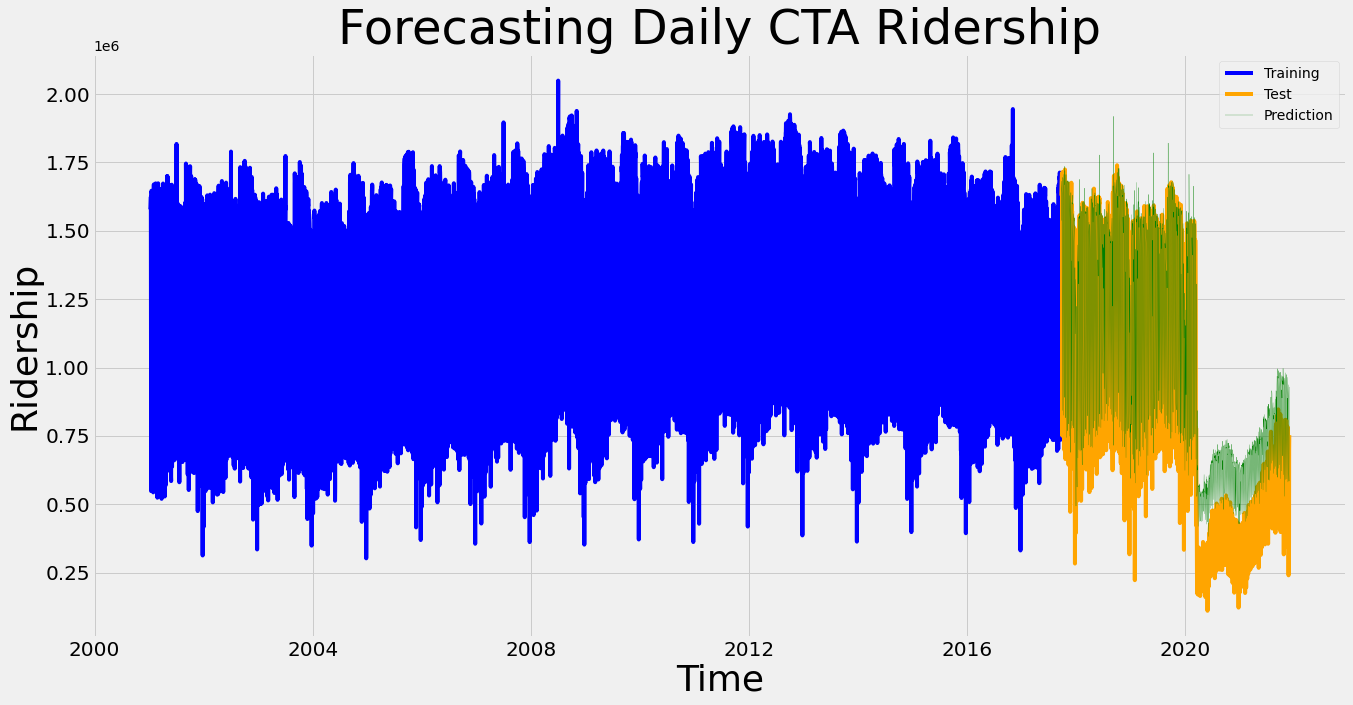

In [35]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction',linewidth=.25)
# Set label.
plt.title(label = 'Forecasting Daily CTA Ridership', fontsize=48)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.xlabel('Time', size=36)
plt.ylabel('Ridership', size=36)

plt.legend();
#plt.savefig('./imgs/Linear-no-annual.png')

Removing the yearly lag seems to make the RMSE and AIC worse, but it handles the shock more elegantly.

## ARIMA

#### Finding '*d*'

In [12]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [13]:
rides['rides_first_diff'] = rides['total_rides'].diff(1)
rides['rides_second_diff'] = rides['total_rides'].diff(1).diff(1)

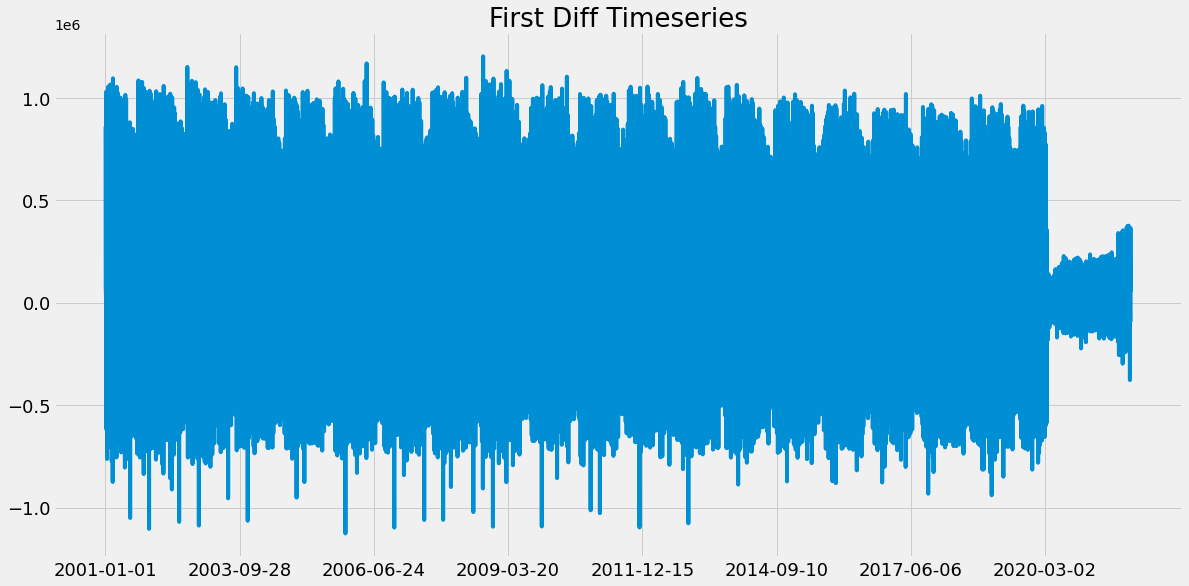

In [14]:
plot_series(rides,['rides_first_diff'], title = 'First Diff Timeseries', steps=1000)

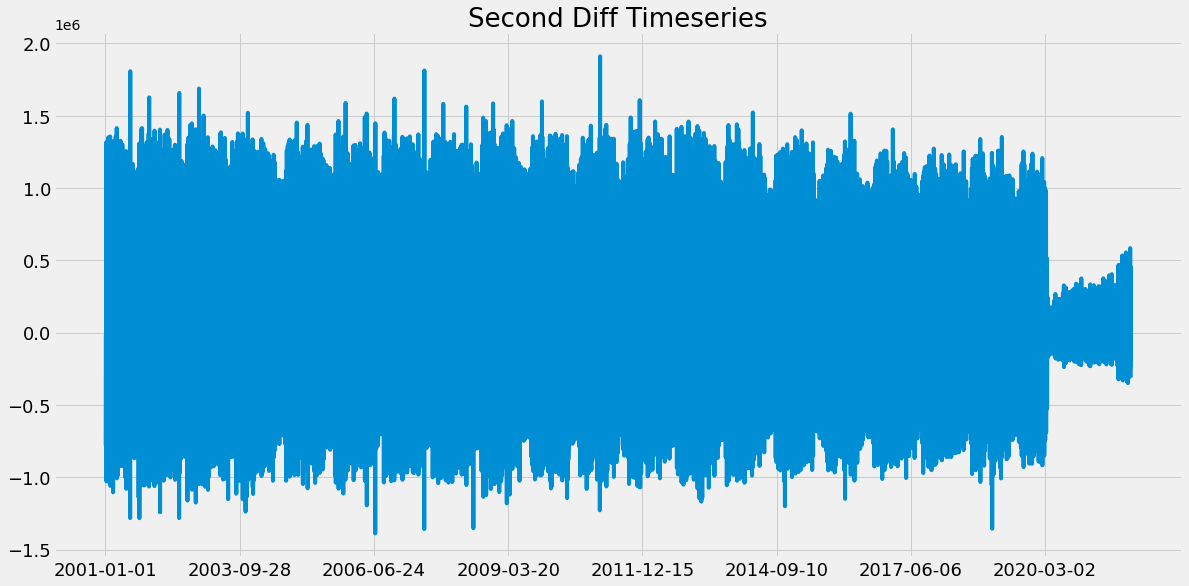

In [15]:
plot_series(rides,['rides_second_diff'], title = 'Second Diff Timeseries', steps=1000)

In [16]:
# Code written by Joseph Nelson
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],index = ['Test Statsitic','p-value'])
    return dfoutput

In [17]:
print(f'Orig: \n{interpret_dftest(adfuller(rides["total_rides"]))}\n\nFirst Diff: \n{interpret_dftest(adfuller(rides["rides_first_diff"].dropna()))}')



Orig: 
Test Statsitic   -2.566741
p-value           0.100068
dtype: float64

First Diff: 
Test Statsitic   -20.419752
p-value            0.000000
dtype: float64


Since in the original data the p-value is not less than 0.05 we cannot reject Null Hypothesis; however, our first order difference is low enough to continue with '*d = 1*.'

#### Finding '*p*' & '*q*'

In [18]:
y_train, y_test = train_test_split(rides['rides_first_diff'], test_size=.2,shuffle=False)

In [ ]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

for p in range(14):
    for q in range(14):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order = (p, 1, q)) 
            
            model = arima.fit()

            if model.aic < best_aic:
                
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('Model Completed.')
print(f'Best ARIMA: ({best_p},1,{best_q}).')
print(f'AIC: {best_aic}.')

In [43]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), 
             order = (9,1,12)) # Endog = Y variable 


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = arima.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])


In [33]:
print(f'AIC: {arima.aic}, RMSE: {metrics.mean_squared_error(y_test,preds,squared=False)}, STD: {rides["total_rides"].std()}')

AIC: 163297.6246061683, RMSE: 182640.854064721, STD: 452648.37201676704


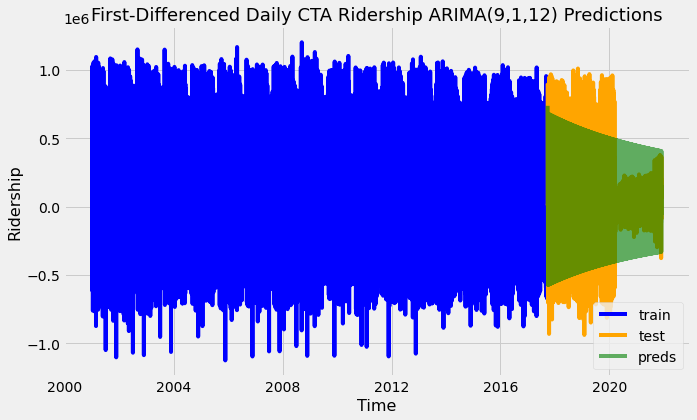

In [46]:
plt.figure(figsize=(10,6))
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'b',label='train')
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange',label='test')
plt.plot(y_test.index,preds,color = 'g',alpha=.60,label='preds')
plt.title(label = 'First-Differenced Daily CTA Ridership ARIMA(9,1,12) Predictions',fontsize=18)
plt.xlabel('Time', size=16)
plt.ylabel('Ridership', size=16)
plt.legend();
plt.savefig('../capstone-data/imgs/ARIMA(9,1,12).png')

The full ARIMA model seems to adjust well to sudden shocks but the predictions aren't that accurate.

In [31]:
y_train.index.duplicated().sum()

0

In [32]:
rides[['rides_first_diff']].dropna()

,rides_first_diff
date,
2001-01-02,859132.0
2001-01-03,78576.0
2001-01-04,58677.0
2001-01-05,28311.0
2001-01-06,-615586.0
...,...
2021-11-26,207606.0
2021-11-27,-22490.0
2021-11-28,-92257.0


In [31]:
y_train, y_test = train_test_split(rides['rides_first_diff'].dropna(), test_size=.2,shuffle=False)

In [232]:
arima_model = auto_arima(y_train,start_p=0,d=1,start_q=0,
                        max_p=12,max_d=1,max_q=12,start_P=0,D=None,start_Q=0,max_P=5,max_D=5,
                        max_Q=5,m=7,seasonal=True,error_action='warn',trace=2,supress_warnings='True',
                        stepwise=True,random_state=42,n_fits=2,n_jobs=-1)

In [258]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                 6110
Model:             SARIMAX(6, 1, 2)x(5, 0, [1, 2, 3], 7)   Log Likelihood              -82419.842
Date:                                   Sun, 06 Feb 2022   AIC                         164875.684
Time:                                           03:57:25   BIC                         164996.599
Sample:                                                0   HQIC                        164917.636
                                                  - 6110                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -192.4644     70.967     -2.712      0.007    -331.557     -53.372
ar.L1         -0.8960      0.057    -15.661      0.000      -1.008      -0.784
ar.L2         -0.7612      0.062    -12.241      0.000      -0.883      -0.639
ar.L3         -0.7134      0.073     -9.760      0.000      -0.857      -0.570
ar.L4         -0.6857      0.081     -8.442      0.000      -0.845      -0.527
ar.L5         -0.6299      0.091     -6.897      0.000      -0.809      -0.451
ar.L6         -0.5204      0.101     -5.166      0.000      -0.718      -0.323
ma.L1         -0.6372      0.060    -10.621      0.000      -0.755      -0.520
ma.L2         -0.2731      0.051     -5.402      0.000      -0.372      -0.174
ar.S.L7       -0.3594      0.190     -1.889      0.059      -0.732       0.013
ar.S.L14       0.4390      0.138      3.171      0.002       0.168       0.710
ar.S.L21       0.4514      0.177      2.546      0.011       0.104       0.799
ar.S.L28       0.2710      0.058      4.654      0.000       0.157       0.385
ar.S.L35       0.1889      0.037      5.106      0.000       0.116       0.261
ma.S.L7        0.0019      0.249      0.008      0.994      -0.486       0.490
ma.S.L14      -0.5648      0.162     -3.493      0.000      -0.882      -0.248
ma.S.L21      -0.2710      0.228     -1.187      0.235      -0.719       0.177
sigma2      5.206e+10   1.99e-06   2.62e+16      0.000    5.21e+10    5.21e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             76380.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -2.63
Prob(H) (two-sided):                  0.08   Kurtosis:                        19.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+31. Standard errors may be unstable.
"""

In [265]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(y_test.index)),index=y_test.index)
prediction.columns = ['pred_ridership']
prediction

,pred_ridership
date,
2017-09-25,7.530073e+05
2017-09-26,1.138858e+05
2017-09-27,3.742637e+04
2017-09-28,2.236236e+03
2017-09-29,-2.688908e+04
...,...
2021-11-26,-1.496702e+06
2021-11-27,-1.835802e+06
2021-11-28,-1.626713e+06


In [266]:
metrics.mean_squared_error(y_test,prediction,squared=False)

729083.4447298878

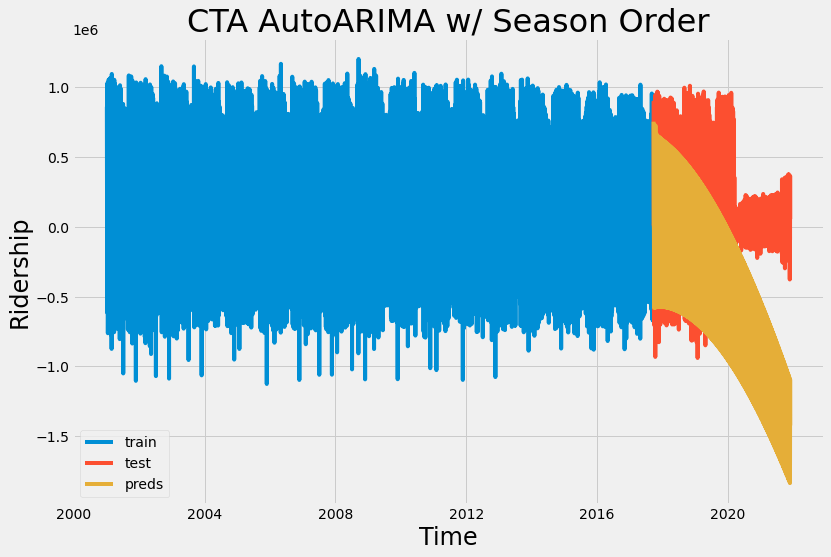

In [267]:
plt.figure(figsize=(12,8))
plt.plot(y_train,label='train')
plt.plot(y_test,label='test')
plt.plot(prediction,label = 'preds')
plt.title('CTA AutoARIMA w/ Season Order',size=32)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership',size=24)
plt.legend(loc = 'lower left')
#plt.savefig('./imgs/ARIMA(6,1,2)(5,0,3)[7].png')

### SARIMAX

In [19]:
model = SARIMAX(y_train.astype(float).dropna(), seasonal_order=(6,1,2,7))
sari = model.fit()

In [20]:
preds_train = sari.predict(start = y_train.index[1], end = y_train.index[-1])
preds = sari.predict(start = y_test.index[0], end = y_test.index[-1])


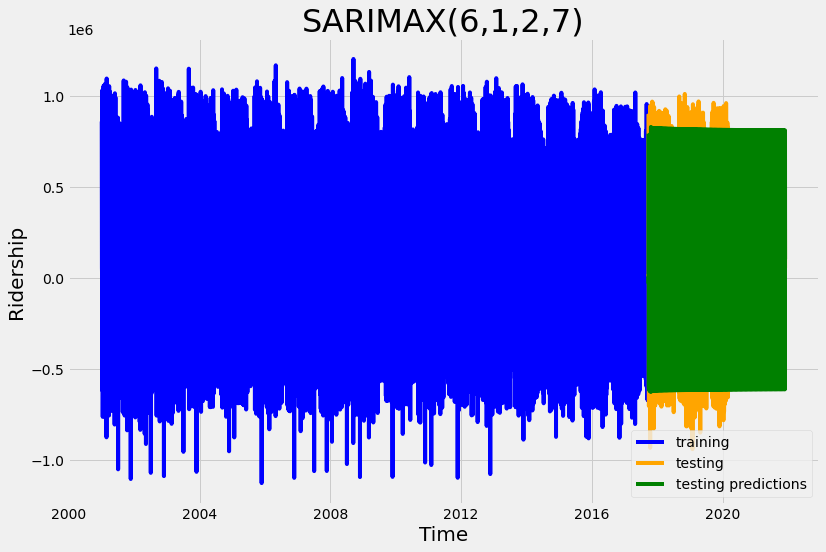

In [24]:
plt.figure(figsize=(12,8))
plt.plot(y_train, color = 'blue', label = 'training')
plt.plot(y_test, color = 'orange', label = 'testing')
plt.plot(preds, color = 'green', label ='testing predictions')
plt.title('SARIMAX(6,1,2,7)',size=32)
plt.xlabel('Time',size=20)
plt.ylabel('Ridership',size=20)
plt.legend();
plt.savefig('../../capstone-data/imgs/Sarimax-daily.png')

In [277]:
print(f'ARIMA(manual): {arima.aic}, \nARIMA(auto): {arima_model.aic()}, \nSARIMAX: {sari.aic}')

ARIMA(manual): 163297.6246061683, 
ARIMA(auto): 164875.68366732943, 
SARIMAX: 164823.30165420118


In [278]:
metrics.mean_squared_error(y_test,preds)

56628560806.99628

# VAR

In [32]:
mv = df[['total_rides','20_yr','gas_close','tmin','StringencyLegacyIndex',
         'first_dose_percent_pop','damage_indicator','ConfirmedDeaths']].copy()

In [33]:
mv

,total_rides,20_yr,gas_close,tmin,StringencyLegacyIndex,first_dose_percent_pop,damage_indicator,ConfirmedDeaths
date,,,,,,,,
2001-01-01,423647.0,5.46,0.7950,13.0,0.00,0.000,0.000000,0.0
2001-01-02,1282779.0,5.46,0.7950,7.0,0.00,0.000,0.000000,0.0
2001-01-03,1361355.0,5.62,0.8100,7.0,0.00,0.000,0.000000,0.0
2001-01-04,1420032.0,5.56,0.8186,23.0,0.00,0.000,0.000000,0.0
2001-01-05,1448343.0,5.50,0.8205,24.0,0.00,0.000,0.000000,0.0
...,...,...,...,...,...,...,...,...
2021-11-26,447394.0,1.89,2.0294,19.0,27.38,0.680,2.634454,28746.0
2021-11-27,424904.0,1.89,2.0294,30.0,34.52,0.681,2.696970,28746.0
2021-11-28,332647.0,1.89,2.0294,26.0,34.52,0.681,2.646552,28746.0


In [34]:
print(f'total_rides 1 diff: \n{interpret_dftest(adfuller(mv["total_rides"].diff(1).dropna()))}')
print()
print(f'20_yr 1 diff: \n{interpret_dftest(adfuller(mv["20_yr"].diff().dropna()))}')
print()

print(f'gas_close 1 diff: \n{interpret_dftest(adfuller(mv["gas_close"].diff().dropna()))}')
print()

print(f'tmin NO diff: \n{interpret_dftest(adfuller(mv["tmin"]))}')
print()

print(f'StringencyLegacyIndex 1 diff: \n{interpret_dftest(adfuller(mv["StringencyLegacyIndex"].diff().dropna()))}')
print()

print(f'first_dose_percent_pop 1 diff: \n{interpret_dftest(adfuller(mv["first_dose_percent_pop"].diff().dropna()))}')
print()

print(f'damage_indicator 1 diff: \n{interpret_dftest(adfuller(mv["damage_indicator"].diff().dropna()))}')
print()

print(f'ConfirmedDeaths 1 diff: \n{interpret_dftest(adfuller(mv["ConfirmedDeaths"].diff().dropna()))}')

total_rides 1 diff: 
Test Statsitic   -20.419752
p-value            0.000000
dtype: float64

20_yr 1 diff: 
Test Statsitic   -46.361808
p-value            0.000000
dtype: float64

gas_close 1 diff: 
Test Statsitic   -1.436868e+01
p-value           9.575738e-27
dtype: float64

tmin NO diff: 
Test Statsitic   -5.900981e+00
p-value           2.778542e-07
dtype: float64

StringencyLegacyIndex 1 diff: 
Test Statsitic   -1.153565e+01
p-value           3.739165e-21
dtype: float64

first_dose_percent_pop 1 diff: 
Test Statsitic   -5.210820
p-value           0.000008
dtype: float64

damage_indicator 1 diff: 
Test Statsitic   -1.881632e+01
p-value           2.022287e-30
dtype: float64

ConfirmedDeaths 1 diff: 
Test Statsitic   -7.871922e+00
p-value           4.958806e-12
dtype: float64


In [35]:
mv['total_rides_diff'] = mv['total_rides'].diff(1)
mv['20_yr_diff'] = mv['20_yr'].diff(1)
mv['gas_close_diff'] = mv['gas_close'].diff(1)
mv['Stringency_diff'] = mv['StringencyLegacyIndex'].diff(1)
mv['first_dose_percent_pop_diff'] = mv['first_dose_percent_pop'].diff(1)
mv['damage_indicator_diff'] = mv['damage_indicator'].diff(1)
mv['ConfirmedDeaths_diff'] = mv['ConfirmedDeaths'].diff(1)

In [37]:
mv2 = mv[['total_rides_diff','20_yr_diff','damage_indicator_diff','tmin']].copy()

In [38]:
train,test = train_test_split(mv2.dropna(),test_size=.25,shuffle=False,random_state=42)

In [39]:
train

,total_rides_diff,20_yr_diff,damage_indicator_diff,tmin
date,,,,
2001-01-02,859132.0,0.00,0.000000,7.0
2001-01-03,78576.0,0.16,0.000000,7.0
2001-01-04,58677.0,-0.06,0.000000,23.0
2001-01-05,28311.0,-0.06,0.000000,24.0
2001-01-06,-615586.0,0.00,0.000000,20.0
...,...,...,...,...
2016-09-03,-563159.0,0.00,0.024658,61.0
2016-09-04,-203477.0,0.00,-0.078810,63.0
2016-09-05,-101568.0,0.00,-0.058258,67.0


In [40]:
model = VAR(train)

In [41]:
ts_model = model.fit(maxlags = 12, ic = 'aic')

In [42]:
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Feb, 2022
Time:                     16:55:40
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.4172
Nobs:                     5716.00    HQIC:                   18.2686
Log likelihood:          -84231.3    FPE:                7.93346e+07
AIC:                      18.1892    Det(Omega_mle):     7.66716e+07
--------------------------------------------------------------------
Results for equation total_rides_diff
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                          2895.315479      6532.295383            0.443           0.658
L1.total_rides_diff              -0.621800         0.013159          -47.253           0.000
L

<Figure size 432x288 with 0 Axes>

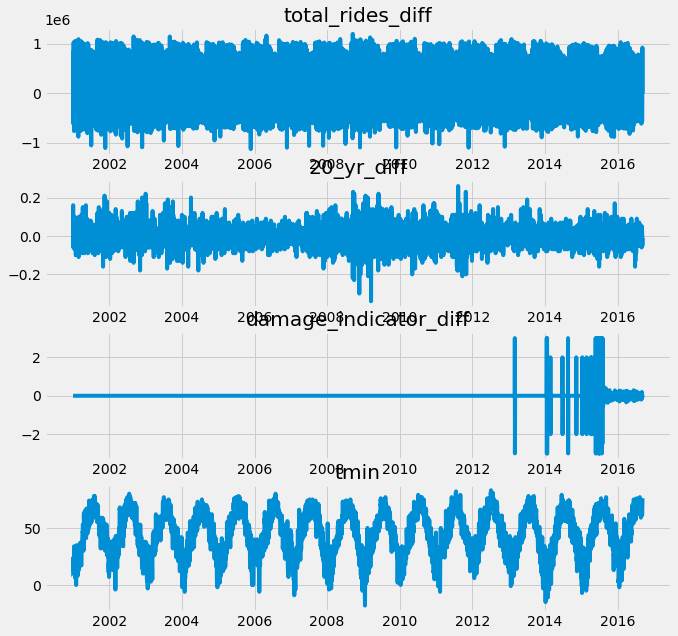

In [47]:
fig = plt.figure()
ts_model.plot();

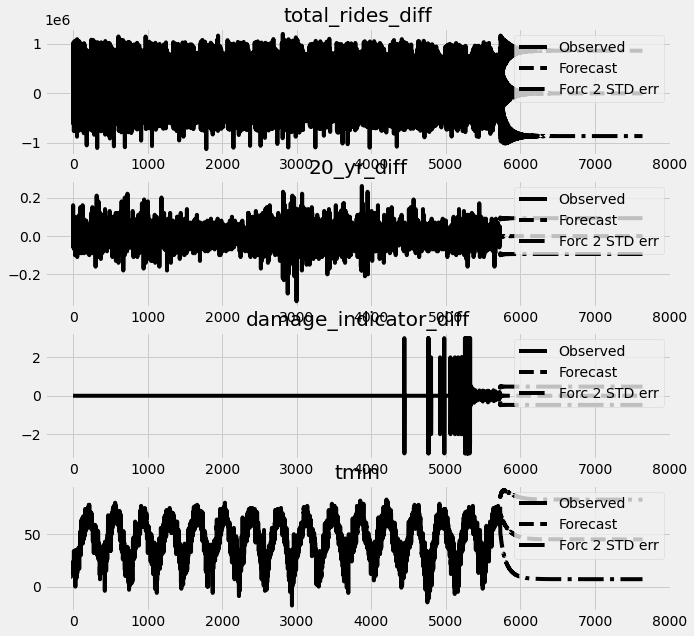

In [45]:
ts_model.plot_forecast(len(test));


In [71]:
train_series = train.to_numpy()

In [99]:
plot_example = pd.DataFrame(ts_model.forecast(train_series,steps=len(test)))[0]

In [46]:
ts_model.aic

18.18918317118889

In [70]:
# Let's use MSE to evaluate our models.

# Save our forecast as forecast.
forecast = ts_model.forecast(train.values, len(test))

# Instantiate MSE values at 0.
mse_riders = 0
mse_20_yr = 0
mse_damage = 0
mse_tmin = 0


# Loop through each forecasted time point.
for time in range(len(test)):
    
    # Calculate (expected - observed) ** 2 and add to MSE.
    mse_riders += (forecast[time][0] - test.values[time][0]) ** 2
    mse_20_yr += (forecast[time][1] - test.values[time][1]) ** 2
    mse_damage += (forecast[time][2] - test.values[time][2]) ** 2
    mse_tmin += (forecast[time][3] - test.values[time][3]) ** 2

# Divide SSE to get MSE.
mse_riders /= len(test)
mse_20_yr /= len(test)
mse_damage /= len(test)
mse_tmin /= len(test)

# Generate output.    
print(f'The test RMSE on the Ridership data is: {round(mse_riders**.5, 4)}')
print(f'The test RMSE on the 20_yr data is: {round(mse_20_yr**.5, 4)}')
print(f'The test RMSE on the damage data is: {round(mse_damage**.5, 4)}')
print(f'The test RMSE on the tmin data is: {round(mse_tmin**.5, 4)}')

The test RMSE on the Ridership data is: 332670.8453
The test RMSE on the 20_yr data is: 0.0375
The test RMSE on the damage data is: 0.0724
The test RMSE on the tmin data is: 19.493


# Prophet

In [3]:
df = pd.read_csv('../capstone-data/daily-merged.csv')

In [4]:
df.rename(columns={'Unnamed: 0':'ds','total_rides':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df[['ds','y']]


In [5]:
def is_covid(ds):
    date = pd.to_datetime(ds)
    return (date.year < 2019 or date.year > 2020) #or (date.year == 2020 and date.month <= 4))

df['on_season'] = df['ds'].apply(is_covid)
df['off_season'] = ~df['ds'].apply(is_covid)


In [6]:
y_train, y_test = train_test_split(df,test_size=.05, shuffle=False,random_state=42)

In [7]:
m = Prophet(yearly_seasonality=False,daily_seasonality=True)#yearly_seasonality=False,n_changepoints=1)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


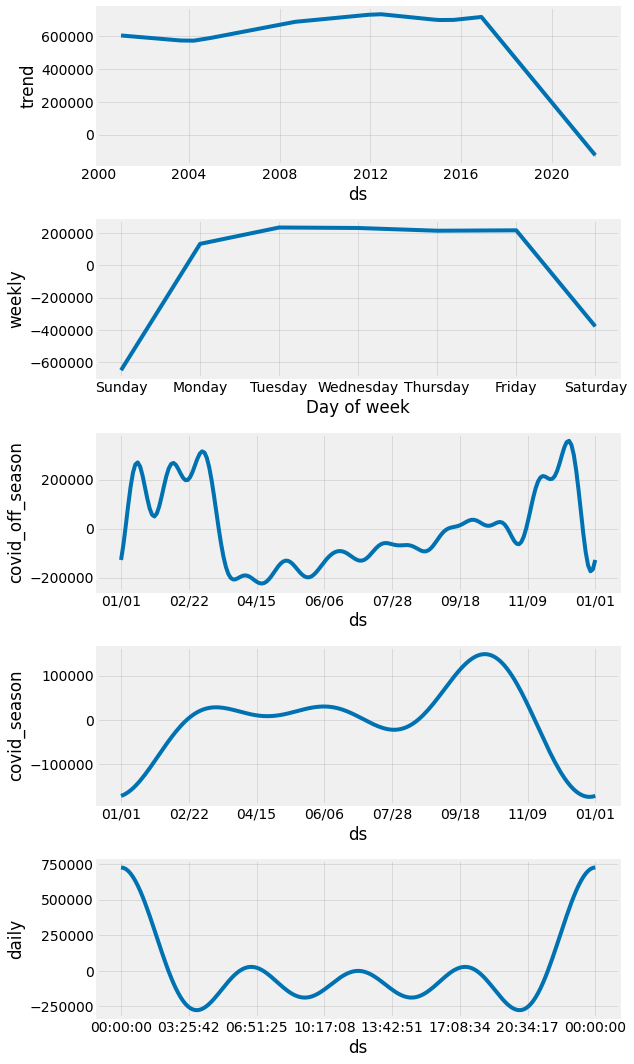

In [8]:
m.add_seasonality(name='covid_season', period=365, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='covid_off_season', period=365, fourier_order=15, condition_name='off_season')
m.fit(y_train)
future = m.make_future_dataframe(periods=len(y_test))
future['on_season'] = future['ds'].apply(is_covid)
future['off_season'] = ~future['ds'].apply(is_covid)
forecast = m.predict(future)
fig = m.plot_components(forecast)
#plt.savefig('./imgs/Prophetdailycomp.png')

In [9]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7634,2021-11-26,748151.138434,511267.097206,989266.354806
7635,2021-11-27,148645.501282,-112179.426081,398488.348352
7636,2021-11-28,-128349.604997,-377505.227329,123018.503104
7637,2021-11-29,645828.477501,411167.684900,903834.111083
7638,2021-11-30,740880.511621,489388.340526,983055.057228


In [10]:
y_test

,ds,y,on_season,off_season
7257,2020-11-14,311191.0,False,True
7258,2020-11-15,212053.0,False,True
7259,2020-11-16,422951.0,False,True
7260,2020-11-17,420728.0,False,True
7261,2020-11-18,428576.0,False,True
...,...,...,...,...
7634,2021-11-26,447394.0,True,False
7635,2021-11-27,424904.0,True,False
7636,2021-11-28,332647.0,True,False
7637,2021-11-29,697412.0,True,False


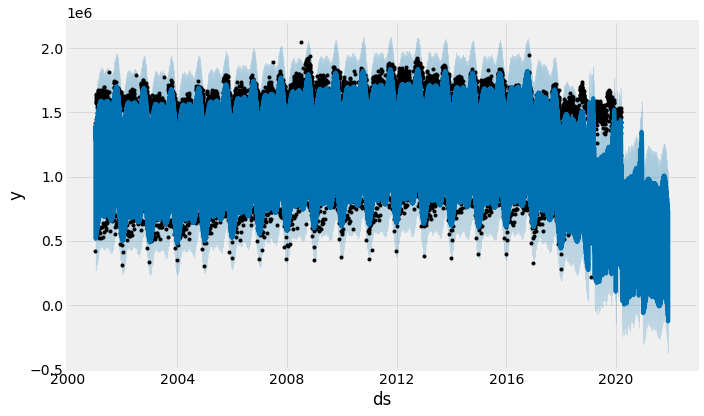

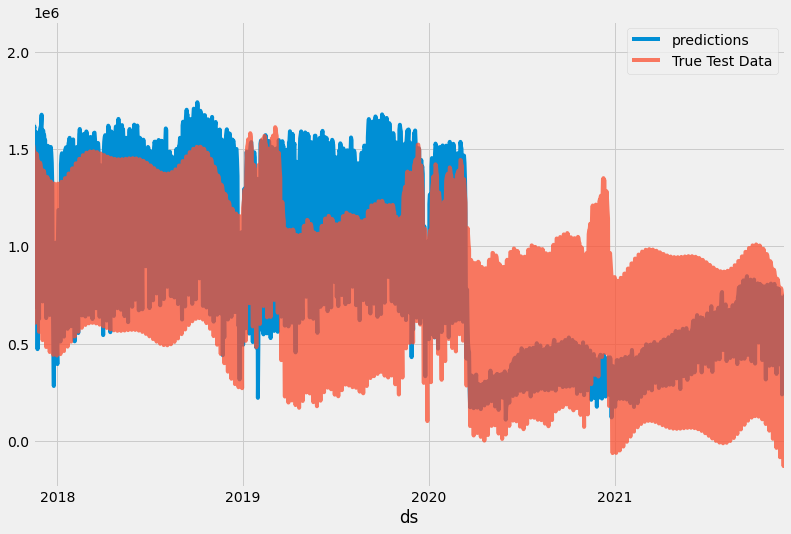

In [11]:
m.plot(forecast)
ax1=df.plot(x='ds',y='y',legend=True,label='predictions',figsize=(12,8),)
forecast.plot(x='ds',y='yhat',legend=True,label='True Test Data',ax=ax1,
              xlim=('2017-11-14','2021-11-30'),alpha=.75);
#plt.savefig('./imgs/Prophetpredsdaily.png')

In [12]:
fig = plot_plotly(m, forecast)
fig.write_html("../capstone-data/imgs/interactive.html")

In [163]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,covid_off_season,covid_off_season_lower,covid_off_season_upper,covid_season,covid_season_lower,covid_season_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,605431.015552,1.071510e+06,1.511130e+06,605431.015552,605431.015552,689910.820844,689910.820844,689910.820844,0.0,0.0,0.0,-173743.921477,-173743.921477,-173743.921477,728484.619505,728484.619505,728484.619505,135170.122817,135170.122817,135170.122817,0.0,0.0,0.0,1.295342e+06
1,2001-01-02,605396.145401,1.174688e+06,1.609504e+06,605396.145401,605396.145401,793415.810450,793415.810450,793415.810450,0.0,0.0,0.0,-173429.551267,-173429.551267,-173429.551267,728484.619505,728484.619505,728484.619505,238360.742212,238360.742212,238360.742212,0.0,0.0,0.0,1.398812e+06
2,2001-01-03,605361.275250,1.172200e+06,1.603514e+06,605361.275250,605361.275250,790557.207875,790557.207875,790557.207875,0.0,0.0,0.0,-172891.582321,-172891.582321,-172891.582321,728484.619505,728484.619505,728484.619505,234964.170691,234964.170691,234964.170691,0.0,0.0,0.0,1.395918e+06
3,2001-01-04,605326.405099,1.169458e+06,1.600149e+06,605326.405099,605326.405099,774615.253080,774615.253080,774615.253080,0.0,0.0,0.0,-172133.334867,-172133.334867,-172133.334867,728484.619505,728484.619505,728484.619505,218263.968442,218263.968442,218263.968442,0.0,0.0,0.0,1.379942e+06
4,2001-01-05,605291.534948,1.172593e+06,1.605499e+06,605291.534948,605291.534948,777957.025986,777957.025986,777957.025986,0.0,0.0,0.0,-171158.538466,-171158.538466,-171158.538466,728484.619505,728484.619505,728484.619505,220630.944947,220630.944947,220630.944947,0.0,0.0,0.0,1.383249e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7634,2021-11-26,317581.517685,9.819339e+05,1.414509e+06,309253.484393,326748.546333,874045.824666,874045.824666,874045.824666,0.0,0.0,0.0,-75069.739787,-75069.739787,-75069.739787,728484.619505,728484.619505,728484.619505,220630.944948,220630.944948,220630.944948,0.0,0.0,0.0,1.191627e+06
7635,2021-11-27,317413.549193,3.649615e+05,7.892649e+05,309067.966299,326603.771666,261731.166189,261731.166189,261731.166189,0.0,0.0,0.0,-80917.680207,-80917.680207,-80917.680207,728484.619505,728484.619505,728484.619505,-385835.773110,-385835.773110,-385835.773110,0.0,0.0,0.0,5.791447e+05
7636,2021-11-28,317245.580701,8.642287e+04,5.234083e+05,308882.448205,326458.996999,-19724.681265,-19724.681265,-19724.681265,0.0,0.0,0.0,-86655.124771,-86655.124771,-86655.124771,728484.619505,728484.619505,728484.619505,-661554.175998,-661554.175998,-661554.175998,0.0,0.0,0.0,2.975209e+05
7637,2021-11-29,317077.612209,8.786707e+05,1.306460e+06,308696.930111,326314.222332,771381.945082,771381.945082,771381.945082,0.0,0.0,0.0,-92272.797237,-92272.797237,-92272.797237,728484.619505,728484.619505,728484.619505,135170.122814,135170.122814,135170.122814,0.0,0.0,0.0,1.088460e+06


In [164]:
forecast['ds']=pd.to_datetime(forecast['ds'])
forecast.set_index('ds',inplace=True)

y_train['ds']=pd.to_datetime(y_train['ds'])
y_train.set_index('ds',inplace=True)

y_test['ds']=pd.to_datetime(y_test['ds'])
y_test.set_index('ds',inplace=True)

In [165]:
y_test

,y,on_season,off_season
ds,,,
2020-05-07,331538.0,False,True
2020-05-08,324509.0,False,True
2020-05-09,266279.0,False,True
2020-05-10,177820.0,False,True
2020-05-11,314171.0,False,True
...,...,...,...
2021-11-26,447394.0,True,False
2021-11-27,424904.0,True,False
2021-11-28,332647.0,True,False


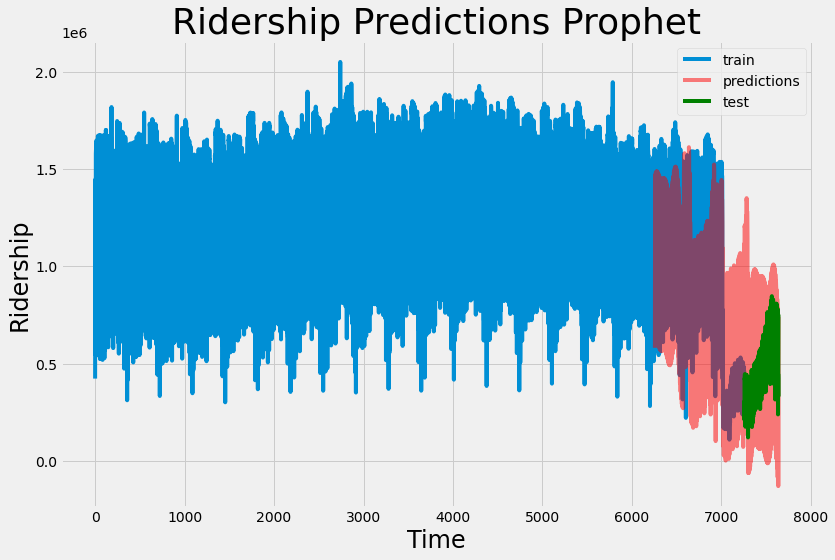

In [186]:
plt.figure(figsize=(12,8))
plt.plot(y_train['y'], label = 'train' )
plt.plot(forecast[['yhat']].tail(len(y_test)+1000),color='r', label ='predictions',alpha=.5)
plt.plot(y_test['y'], label='test',color='green')
plt.title('Ridership Predictions Prophet', size=36)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership',size=24)
plt.legend();
plt.savefig('./imgs/Prophetpredsdaily2.png')

In [198]:
forecast[['yhat']]

,yhat
0,1.290727e+06
1,1.391945e+06
2,1.389366e+06
3,1.373025e+06
4,1.376393e+06
...,...
7634,7.481511e+05
7635,1.486455e+05
7636,-1.283496e+05
7637,6.458285e+05


In [202]:
pro_preds = forecast[['yhat']].tail(len(y_test))
metrics.mean_squared_error(y_test[['y']], pro_preds,squared=False)

373906.8889071253

In [187]:
initial= '5000 days'
period= '365 days'
horizon = 365/2
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,horizon)
# Performance Metrics of fb_cv
performance_metrics(fb_cv,rolling_window=.01)

INFO:fbprophet:Making 72 forecasts with cutoffs between 2002-08-18 18:00:00 and 2020-05-14 12:00:00


  0%|          | 0/72 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days 00:00:00,1.600478e+10,126510.004426,80993.592051,0.083317,0.040256,0.931298
1,2 days 06:00:00,1.349120e+10,116151.642153,83275.422186,0.076400,0.044398,0.929177
2,2 days 12:00:00,1.021748e+10,101081.564113,74794.631705,0.072817,0.044038,0.947837
3,2 days 18:00:00,1.163009e+10,107842.896467,76246.983404,0.077786,0.040256,0.931298
4,3 days 00:00:00,1.209645e+10,109983.884607,78706.769808,0.079068,0.040390,0.931298
...,...,...,...,...,...,...,...
718,181 days 12:00:00,5.542555e+10,235426.323677,111070.928372,0.162339,0.043967,0.936811
719,181 days 18:00:00,5.277550e+10,229729.183333,109839.563126,0.153200,0.043967,0.936811
720,182 days 00:00:00,5.955882e+10,244046.758922,110589.263043,0.171913,0.038581,0.936811
721,182 days 06:00:00,5.439776e+10,233233.277051,107566.277144,0.161154,0.039874,0.929177


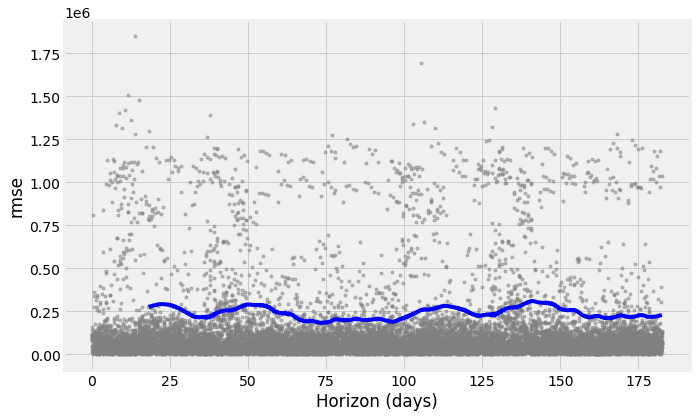

In [188]:
plot_cross_validation_metric(fb_cv,'rmse');

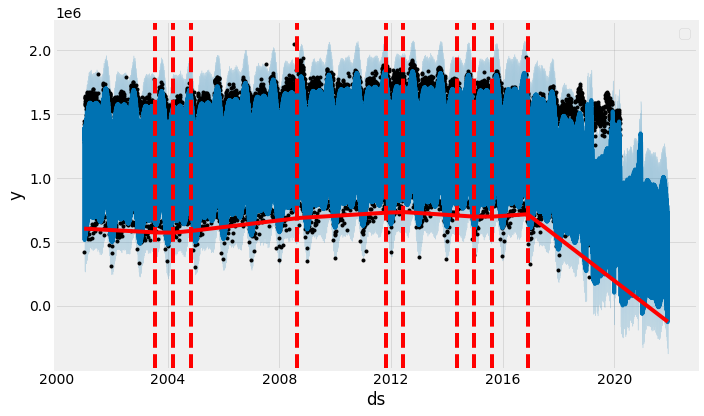

In [191]:
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)
#plt.savefig('./imgs/ProphetDailyTrendweakness.png')

# LinearRegression

In [308]:
df.columns

Index(['bus', 'rail_boardings', 'total_rides', 'prcp', 'tmax', 'tmin',
       'gas_open', 'gas_close', 'gas_volume', '3_mo', '6_mo', '1_yr', '2_yr',
       '3_yr', '5_yr', '7_yr', '10_yr', '20_yr', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyLegacyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'total_daily_doses',
       'total_daily_cum', 'first_dose_daily', 'first_dose_cum',
       'first_dose_percent_pop', 'vax_

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
X=df.drop(columns={'bus','rail_boardings','total_rides','prcp', 'tmax','gas_open','gas_volume', '3_mo', '6_mo',
                  'ContainmentHealthIndex', 'EconomicSupportIndex','StringencyIndex'})
y =df['total_rides']

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42,)#shuffle=False)

In [50]:
lr = LinearRegression()

In [51]:
lr.fit(X_train,y_train)

LinearRegression()

In [52]:
lr.score(X_train,y_train),lr.score(X_test,y_test)

(0.34904547366046923, 0.3146797506015052)

In [53]:
preds=lr.predict(X_test)

In [54]:
metrics.mean_squared_error(y_test,preds,squared=False)

371335.5658100492

In [339]:
from sklearn.ensemble import RandomForestRegressor

In [364]:
import xgboost as xgb

In [340]:
from sklearn.model_selection import GridSearchCV

# RandomForest

In [354]:
X=df.drop(columns={'bus','rail_boardings','total_rides', 'tmax','gas_volume', '3_mo', '6_mo',
                  'StringencyIndex'})
y =df['total_rides']

In [355]:
rf = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators':range(100,1000,100),
    'max_depth': range(4,11),
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [1],
}

rf_grid = GridSearchCV(rf,rf_params,cv=5,verbose=1,n_jobs=-1)

In [356]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(4, 11), 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': range(100, 1000, 100)},
             verbose=1)

In [357]:
rf_grid.best_params_

{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 800}

In [358]:
rf_grid.score(X_train,y_train),rf_grid.score(X_test,y_test)


(0.41670699160138946, 0.35975955735578113)

In [360]:
preds = rf_grid.predict(X_test)

In [361]:
metrics.mean_squared_error(y_test,preds,squared=False)

358914.7587124142

# XGBoost

In [372]:
boost = xgb.XGBRegressor(booster = 'gbtree', random_seed=42)

xg_params= {
    'eta': [.1,.2,.4,.5,.8,1],
    'gamma': [0,1,2],
    'max_depth': range(1,11,1),
    'subsample':[.5,1]
}

boost_grid = GridSearchCV(boost,xg_params,n_jobs=-1,cv=5,verbose=1)

In [373]:
boost_grid.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[05:28:56] WARNING: ../src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_seed=42, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
          

In [374]:
boost_grid.best_params_

{'eta': 0.1, 'gamma': 0, 'max_depth': 2, 'subsample': 1}

In [376]:
boost_grid.score(X_train,y_train),boost_grid.score(X_test,y_test)

(0.401040295399407, 0.36195145081238944)

In [382]:
preds = boost_grid.predict(X_test)
metrics.mean_squared_error(y_test,preds,squared=False)

358299.8511383388

In [378]:
boost = xgb.XGBRegressor(booster = 'gblinear', random_seed=42)

boost.fit(X_train,y_train)

[05:33:16] WARNING: ../src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=16, num_parallel_tree=None,
             predictor=None, random_seed=42, random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

In [380]:
boost.score(X_train,y_train),boost.score(X_test,y_test)

(0.33841750257738035, 0.3121666375290709)

In [381]:
preds= boost.predict(X_test)
metrics.mean_squared_error(y_test,preds)

138395754237.37375

| Model                                 | RMSE               | AIC/R2     |
|---------------------------------------|--------------------|------------|
| Linear w/ annual                      | 317,766.52         | 151,287.11 |
| Linear w/o annual                     | 207,743.97         | 165,448.67 |
| ARIMA(9,1,12)                         | 182,640.85         | 163,297.62 |
| SARIMAX(6, 1, 2)x(5, 0, [1, 2, 3], 7) | 729,083.44         | 164,875.68 |
| SARIMAX(6,1,2,7)                      | 56,628,560,806     | 164,823.30 |
| VAR                                   | 335,815.98         | 18.18      |
| Prophet                               | 373,906.89         | N/A        |
| RandomForest                          | 358,914.75         | 0.35       |
| LinearRegression                      | 137,890,102,435.47 | 0.31       |
| XGBoost                               | 358,299.85         | 0.36       |
|                                   Mean: 1,292,590.61     | STD:  452,648.37    | |